In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import datetime as dt
import warnings
import time
from matplotlib import pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
from sksurv.ensemble import RandomSurvivalForest, ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import eli5
from eli5.sklearn import PermutationImportance

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder


In [2]:
#load data
pd.set_option('display.max_columns', None)
df = pd.read_csv('imputed_vent.csv')
#df = df.drop(axis=1, columns=['Unnamed: 0','last_careunit'])

In [3]:
# get combined cabg and valve surgery, or combined valve surgery
def get_surgtype(a,p,t,m,cabg): 
    surg_V = a+p+t+m
    surg_multiV = 0
    surg_CnV = 0
    if surg_V >= 1 and cabg == 1:
        surg_CnV = 1
    if surg_V > 1 and cabg == 0:
        surg_multiV = 1
    if surg_multiV == 1 or surg_CnV == 1:
        a=0
        p=0
        t=0
        m=0
        cabg=0
    return a,p,t,m,cabg,surg_multiV,surg_CnV

#generating surg type columns
aList = []
pList = []
tList = []
mList = []
cabgList = []
multiVList = []
CnVList = []


for i in range(len(df)):
    y = get_surgtype(df['aortic'][i],df['pulmonary'][i],df['tricuspid'][i],df['mitral'][i],df['cabg'][i])
    aList.append(y[0])
    pList.append(y[1])
    tList.append(y[2])
    mList.append(y[3])
    cabgList.append(y[4])
    multiVList.append(y[5])
    CnVList.append(y[6])
df['aortic'] = aList
df['pulmonary'] = pList
df['tricuspid'] = tList
df['mitral'] = mList
df['cabg'] = cabgList
df['multi_valve'] = multiVList
df['cabg_valve'] = CnVList

In [4]:
df.head(10)

,Unnamed: 0,temp_first,temp_last,hr_first,hr_last,spo2_first,spo2_last,rr_first,rr_last,sbp_first,sbp_last,dbp_first,dbp_last,meanbp_first,meanbp_last,cardiac_index_first,cardiac_index_last,pt_first,pt_last,ptt_first,ptt_last,inr_first,inr_last,hb_first,hb_last,wcc_first,wcc_last,chloride_first,chloride_last,potassium_first,potassium_last,creatinine_first,creatinine_last,free_calcium_first,free_calcium_last,sodium_first,sodium_last,bicarb_first,bicarb_last,bun_first,bun_last,glucose_first,glucose_last,lactate_last,aki_first,aki_last,po2_first,po2_last,pco2_first,pco2_last,baseexcess_first,baseexcess_last,ph_first,ph_last,fio2_first,fio2_last,insulin_first,insulin_last,plt_first,plt_last,dtoutput_first,dtoutput_last,padp_first,padp_last,tvobs_first,tvobs_last,tvobs_mean,tvobs_max,tvobs_min,tvset_first,tvset_last,tvset_mean,tvset_max,tvset_min,minute_volume_first,minute_volume_last,minute_volume_mean,minute_volume_max,minute_volume_min,plat_first,plat_last,plat_mean,plat_max,plat_min,peep_first,peep_last,peep_mean,peep_max,peep_min,fio2_mean,fio2_max,fio2_min,rrset_first,rrset_last,rrset_mean,rrset_max,rrset_min,rrtotal_first,rrtotal_last,rrtotal_mean,rrtotal_max,rrtotal_min,rrspont_first,rrspont_last,rrspont_mean,rrspont_max,rrspont_min,inotropes_duration,inotropes_bool,inotropes_count,infection_first,infection_vent,age,gender,ethnicity,marital_status,insurance,language,aortic,mitral,tricuspid,pulmonary,cabg,multi_valve,cabg_valve,weight,height,bmi,sofa,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,last_careunit,admission_location,admission_type,hospital_expire_flag,diab_un,diab_cc,duration1,prbc_sum,prbc_bool,ffp_sum,ffp_bool,cryo_sum,cryo_bool,plts_sum,plts_bool,icu_stay_duration,admittime,dischtime,intime,outtime,ext_time,los,icustay_seq,deathtime,first_readmission,readmissions,hadm_id,subject_id,int_time1,ext_time1,int_time2,ext_time2,duration2
0,0,38.000000,38.000000,100.0,100.0,100.0,100.0,21.0,21.0,100.0,100.0,51.0,51.0,66.0,66.0,3.19502,3.19502,14.6,14.5,31.2,41.9,1.3,1.3,9.1,9.9,17.2,21.0,105.0,109.0,4.7,4.0,0.6,0.5,1.16,1.27,138.0,138.0,27.0,25.0,11.0,8.0,147.0,120.0,1.5,0.0,0.0,-2.0,0.0,37.0,51.0,-2.0,0.0,7.38,7.34,1.0,0.5,0.0,313.0,309.0,356.0,0.0,0.0,20.0,20.0,400.0,460.0,470.000000,550.0,400.0,520.0,520.0,510.000000,520.00,510.0,6.6,11.4,7.933333,11.4,5.8,17.8,18.0,18.0,18.6,17.700001,5.0,5.0,5.000000,5.0,5.0,0.640000,1.0,0.5,16.0,16.0,16.666667,17.0,16.0,16.0,16.0,15.666667,16.0,15.0,1.0,0.0,0.000000,0.0,0.0,0.00,1.0,2.0,0,0,19.0,F,white,SINGLE,Private,ENGL,0,1,0,0,0,0,0,115.4,170.18,39.846371,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,CSRU,CSRU,EMERGENCY ROOM,EMERGENCY,0,0,0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92540.0,2148-12-15 00:19:00,2149-01-04 15:45:00,2148-12-23 13:00:34,2148-12-24 16:42:20,2148-12-23 18:00:00,1.1540,2,NaN,NaN,NaN,132385,28772,2148-12-23 15:00:00,2148-12-23 18:00:00,NaN,NaN,NaN
1,1,36.599998,36.500000,106.0,104.0,95.0,95.0,23.0,16.0,115.0,114.0,72.0,71.0,85.0,85.0,4.13613,4.18848,16.5,19.9,31.9,47.8,1.5,1.8,9.6,8.6,18.1,34.7,104.0,109.0,4.6,3.9,0.7,0.6,1.00,1.13,137.0,139.0,24.0,24.0,15.0,15.0,96.0,121.0,1.4,0.0,0.0,0.0,0.0,37.0,34.0,0.0,0.0,7.44,7.43,1.0,0.4,317.0,242.0,241.0,222.0,40.0,20.0,21.0,19.0,661.0,567.0,678.000000,806.0,567.0,510.0,450.0,475.000000,500.00,450.0,7.7,14.0,10.850000,14.0,7.7,18.0,18.0,18.0,18.0,18.000000,5.0,5.0,5.000000,5.0,5.0,0.600000,1.0,0.4,14.0,15.0,15.500000,18.0,14.0,20.0,16.0,16.000000,16.0,16.0,0.0,11.0,4.666667,11.0,0.0,2.50,1.0,2.0,0,0,22.0,M,white,SINGLE,Private,PORT,0,0,0,0,0,0,0,71.1,190.50,19.592039,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CSRU,CSRU,EMERGENCY ROOM,EMERGENCY,0,0,0,2.683333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107383.0,2166-09-24 20:15:00,2166-10-20 13:30:00,2166-10-06 09:41:05,2166-10-07 17:19:43,2166-10-06 14:11:00,1.3185,2,NaN,NaN,NaN,109148,16927,2166-10-06 11:30:00,2166-10-06 14:11:00,NaN,NaN,NaN
2,2,37.200001,37.200001,90.0

## 1: Post-pre-processing

#### 1.1: Variable grouping

In [5]:
# variables for analysis
categorical = ['ethnicity', 
              'marital_status',
              'language',
              'admission_location',
              'gender',
              'insurance',
              'first_careunit',
              'admission_type']
proceduretype=['aortic','mitral','tricuspid','pulmonary','cabg','multi_valve','cabg_valve']
ptParams = ['weight', 'height', 'bmi', 'sofa', 'age','inotropes_duration','inotropes_count','prbc_sum','cryo_sum','plts_sum','ffp_sum']
ptParams_first = ['weight', 'height', 'bmi', 'sofa', 'age','prbc_sum','cryo_sum','plts_sum','ffp_sum']
boolFields = ['reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids', 'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia', 
              'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia', 'hospital_expire_flag', 'diab_un', 'diab_cc','infection_vent','inotropes_bool',
              'prbc_bool','cryo_bool','plts_bool','ffp_bool']
ptinfo = ['hadm_id', 'subject_id']
ptTimes = ['int_time1','ext_time1','int_time2','ext_time2','admittime', 'dischtime', 'deathtime','intime', 'outtime', 'ext_time', 'icustay_seq']
tsColumns_first = [i for i in df.columns if '_first' in i]
tsColumns_last = [i for i in df.columns if '_last' in i]
tsColumns_others = [i for i in df.columns if '_max' in i or '_min' in i or '_mean' in i]

inputs = [*categorical , *proceduretype , *tsColumns_first, *tsColumns_last, *ptParams_first , *[i for i in boolFields if i != 'reintubation' and i != 'hospital_expire_flag' and i != 'infection_vent']]
inputs_all = [*categorical , *proceduretype , *tsColumns_first , *tsColumns_others, *ptParams , *[i for i in boolFields if i != 'reintubation' and i != 'hospital_expire_flag']]
outcomes = ['reintubation','hospital_expire_flag','los','duration1','duration2','icu_stay_duration']

print([i for i in df.columns if i not in categorical + proceduretype + tsColumns_first + tsColumns_last + tsColumns_others + ptParams + boolFields + ptinfo + ptTimes + outcomes])
print([i for i in df.columns if i not in inputs + outcomes + ptTimes + tsColumns_others + tsColumns_last])


['Unnamed: 0', 'last_careunit', 'first_readmission', 'readmissions']
['Unnamed: 0', 'inotropes_duration', 'inotropes_count', 'infection_vent', 'last_careunit', 'first_readmission', 'readmissions', 'hadm_id', 'subject_id']


In [6]:
# change categorical to category type
for col in categorical:
    df[col] = df[col].astype('category')

In [7]:
# create censor column for death before extubation
censor = []
for i in range(len(df)):
    if df['deathtime'][i] is np.NaN:
        censor.append(True)
        continue
    deathtime = dt.datetime.strptime(df['deathtime'][i], '%Y-%m-%d %H:%M:%S')
    try: 
        exttime = dt.datetime.strptime(df['ext_time1'][i], '%Y-%m-%d %H:%M:%S')
    except:
        censor.append(True)
        continue
    if deathtime >= exttime:
        censor.append(True)
    else:
        censor.append(False)
censored = []
for i in range(len(censor)):
    if censor[i] == False:
        censored.append(i)
print('Number censored: '+str(len(censored)))
print(censored)

df['censor'] = censor

Number censored: 5
[3151, 3454, 3728, 4530, 6103]


In [8]:
df[inputs]

,ethnicity,marital_status,language,admission_location,gender,insurance,first_careunit,admission_type,aortic,mitral,tricuspid,pulmonary,cabg,multi_valve,cabg_valve,temp_first,hr_first,spo2_first,rr_first,sbp_first,dbp_first,meanbp_first,cardiac_index_first,pt_first,ptt_first,inr_first,hb_first,wcc_first,chloride_first,potassium_first,creatinine_first,free_calcium_first,sodium_first,bicarb_first,bun_first,glucose_first,aki_first,po2_first,pco2_first,baseexcess_first,ph_first,fio2_first,insulin_first,plt_first,dtoutput_first,padp_first,tvobs_first,tvset_first,minute_volume_first,plat_first,peep_first,rrset_first,rrtotal_first,rrspont_first,infection_first,temp_last,hr_last,spo2_last,rr_last,sbp_last,dbp_last,meanbp_last,cardiac_index_last,pt_last,ptt_last,inr_last,hb_last,wcc_last,chloride_last,potassium_last,creatinine_last,free_calcium_last,sodium_last,bicarb_last,bun_last,glucose_last,lactate_last,aki_last,po2_last,pco2_last,baseexcess_last,ph_last,fio2_last,insulin_last,plt_last,dtoutput_last,padp_last,tvobs_last,tvset_last,minute_volume_last,plat_last,peep_last,rrset_last,rrtotal_last,rrspont_last,weight,height,bmi,sofa,age,prbc_sum,cryo_sum,plts_sum,ffp_sum,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,diab_un,diab_cc,inotropes_bool,prbc_bool,cryo_bool,plts_bool,ffp_bool
0,white,SINGLE,ENGL,EMERGENCY ROOM,F,Private,CSRU,EMERGENCY,0,1,0,0,0,0,0,38.000000,100.0,100.0,21.0,100.0,51.0,66.0,3.19502,14.6,31.2,1.3,9.1,17.2,105.0,4.7,0.6,1.16,138.0,27.0,11.0,147.0,0.0,-2.0,37.0,-2.0,7.38,1.0,0.000000,309.0,0.0,20.0,400.0,520.0,6.6,17.800000,5.0,16.0,16.0,1.0,0,38.000000,100.0,100.0,21.0,100.0,51.0,66.0,3.19502,14.5,41.9,1.3,9.9,21.0,109.0,4.0,0.5,1.27,138.0,25.0,8.0,120.0,1.5,0.0,0.0,51.0,0.0,7.34,0.5,313.000000,356.0,0.0,20.0,460.0,520.0,11.4,18.0,5.0,16.0,16.0,0.0,115.40,170.18,39.846371,2,19.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,white,SINGLE,PORT,EMERGENCY ROOM,M,Private,CSRU,EMERGENCY,0,0,0,0,0,0,0,36.599998,106.0,95.0,23.0,115.0,72.0,85.0,4.13613,16.5,31.9,1.5,9.6,18.1,104.0,4.6,0.7,1.00,137.0,24.0,15.0,96.0,0.0,0.0,37.0,0.0,7.44,1.0,317.000000,241.0,40.0,21.0,661.0,510.0,7.7,18.000000,5.0,14.0,20.0,0.0,0,36.500000,104.0,95.0,16.0,114.0,71.0,85.0,4.18848,19.9,47.8,1.8,8.6,34.7,109.0,3.9,0.6,1.13,139.0,24.0,15.0,121.0,1.4,0.0,0.0,34.0,0.0,7.43,0.4,242.000000,222.0,20.0,19.0,567.0,450.0,14.0,18.0,5.0,15.0,16.0,11.0,71.10,190.50,19.592039,5,22.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
2,asian,SINGLE,PORT,PHYSICIAN REFERRAL,M,Private,CSRU,ELECTIVE,0,1,0,0,0,0,0,37.200001,90.0,100.0,17.0,112.0,58.0,73.0,3.46154,14.5,33.5,1.3,9.0,9.2,99.0,4.6,0.5,1.07,133.0,27.0,7.0,134.0,0.0,-5.0,41.0,-5.0,7.30,1.0,180.000000,124.0,40.0,15.0,570.0,450.0,6.9,15.000000,5.0,15.0,15.0,8.0,0,37.200001,90.0,100.0,17.0,112.0,58.0,73.0,3.46154,16.6,43.3,1.5,10.0,6.9,111.0,4.0,0.5,1.00,143.0,24.0,7.0,136.0,1.5,0.0,-2.0,47.0,-2.0,7.31,0.4,285.000000,116.0,40.0,15.0,483.0,400.0,10.4,16.0,5.0,17.0,16.0,12.0,66.00,182.88,19.733836,7,22.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,white,SINGLE,ENGL,PHYSICIAN REFERRAL,M,Private,CSRU,EMERGENCY,1,0,0,0,0,0,0,36.599998,108.0,100.0,12.0,100.0,60.0,74.0,3.26633,12.4,28.5,1.0,10.8,18.5,106.0,4.2,0.6,1.08,141.0,27.0,10.0,101.0,0.0,3.0,55.0,3.0,7.36,1.0,0.000000,296.0,50.0,6.0,787.0,450.0,8.5,22.000000,5.0,16.0,15.0,6.0,1,36.599998,110.0,100.0,15.0,96.0,62.0,73.0,3.06533,14.8,34.9,1.4,10.5,21.8,107.0,3.5,0.5,1.24,138.0,24.0,11.0,113.0,1.2,0.0,2.0,44.0,2.0,7.40,0.4,362.000000,227.0,5.0,8.0,725.0,480.0,9.1,21.0,5.0,14.0,18.0,0.0,78.00,182.88,23.321806,3,23.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,white,SINGLE,CAPE,PHYSICIAN REFERRAL,F,Private,CSRU,ELECTIVE,0,1,0,0,0,0,0,36.799999,86.0,100.0,16.0,95.0,54.0,70.0,2.41753,18.3,49.2,1.7,11.5,21.6,107.0,4.3,0.8,1.22,137.0,22.0,12.0,204.0,2.0,-1

#### 1.2: !!X, Xt, y!!

In [39]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Xt_scaled = StandardScaler().fit_transform(Xt, y=None)
Xt = Xt_scaled
Scaler = StandardScaler().fit(Xt,y=None)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] = df['duration1']
y

array([( True, 3.        ), ( True, 2.68333333), ( True, 3.25      ), ...,
       ( True, 9.        ), ( True, 3.        ), ( True, 6.        )],
      dtype=[('Censor', '?'), ('Survival', '<f8')])

In [10]:
Xt

array([[-0.20356287, -0.18688918, -0.06282103, ..., -0.25631894,
        -0.33030669, -0.32994951],
       [-0.20356287, -0.18688918, -0.06282103, ..., -0.25631894,
        -0.33030669, -0.32994951],
       [-0.20356287, -0.18688918, -0.06282103, ..., -0.25631894,
        -0.33030669, -0.32994951],
       ...,
       [-0.20356287, -0.18688918, -0.06282103, ..., -0.25631894,
        -0.33030669, -0.32994951],
       [-0.20356287, -0.18688918, -0.06282103, ..., -0.25631894,
        -0.33030669, -0.32994951],
       [ 4.91248716, -0.18688918, -0.06282103, ..., -0.25631894,
        -0.33030669, -0.32994951]])

#### 1.3: Plotting y

In [11]:
pd.DataFrame(y).dropna()

,Censor,Survival
0,True,3.000000
1,True,2.683333
2,True,3.250000
3,True,8.500000
4,True,4.666667
...,...,...
10425,True,4.000000
10426,True,14.000000
10427,True,9.000000
10428,True,3.000000


In [12]:
y['Survival'].max()

968.1666666666666

Text(0.5, 0, 'time $t$')

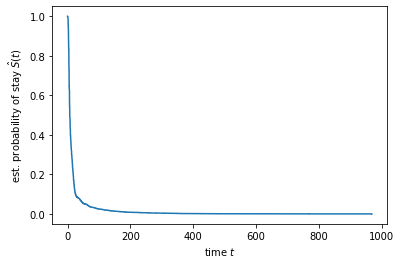

In [13]:
# view the data
time, survival_prob = kaplan_meier_estimator(y["Censor"], y["Survival"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of stay $\hat{S}(t)$")
plt.xlabel("time $t$")

(array([ 802., 3111., 2044.,  939.,  684., 1103.,  650.,  203.,   59.,
          83.,  118.]),
 array([ 0,  3,  6,  9, 12, 15, 20, 25, 30, 35, 40, 45]),
 <BarContainer object of 11 artists>)

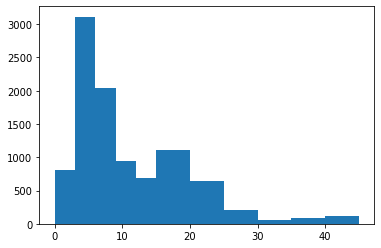

In [14]:
plt.hist(y["Survival"],bins=[0,3,6,9,12,15,20,25,30,*list(range(35,50,5))],range=(0,50))

## 2: Survival Analysis

### 2.1: Cox elastic net

In [15]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Xt_scaled = StandardScaler().fit_transform(Xt, y=None)

In [16]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.0001, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, l1_ratio=0.9,
                                        max_iter=100))])

In [17]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis()),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(Xt_scaled, y)

cv_results = pd.DataFrame(gcv.cv_results_)

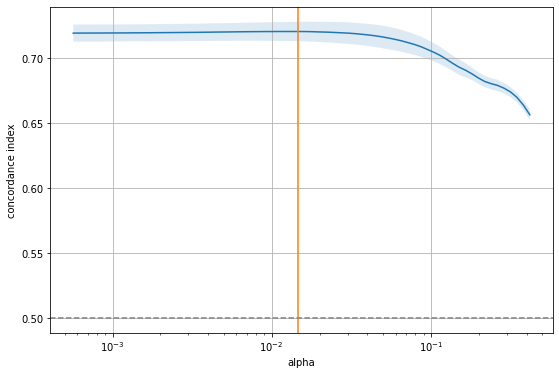

In [18]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [19]:
best_alpha = gcv.best_params_["coxnetsurvivalanalysis__alphas"][0]
print(best_alpha)

0.014707216452313186


Number of non-zero coefficients: 115


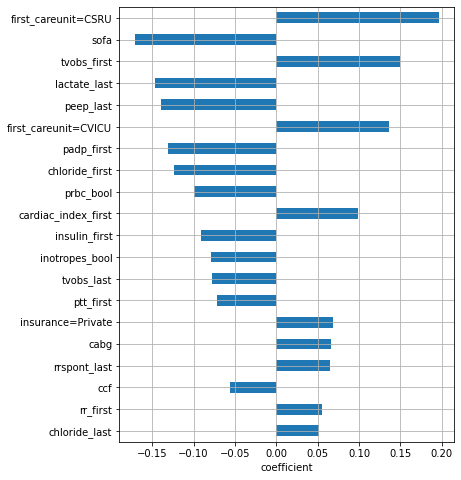

In [20]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order[-20:]].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### 2.2 Hyperparameter tuning

In [21]:
# Initialise cross validation and scoring function

cv = KFold(n_splits=5, shuffle=True, random_state=0)
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

In [22]:
#1. RF
rsf = RandomSurvivalForest()

gcvrf = GridSearchCV(
    rsf,
    param_grid = {'min_samples_leaf': [2,4,6,8],
                  #'n_estimators': [50,200]
                  },
    cv=cv,
    scoring = score_survival_model,
    n_jobs=1, verbose=2).fit(Xt_scaled, y)


# get results
rf_cv_results = pd.DataFrame(gcvrf.cv_results_)
print(rf_cv_results)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .................................min_samples_leaf=2; total time= 6.6min
[CV] END .................................min_samples_leaf=2; total time= 6.8min
[CV] END .................................min_samples_leaf=2; total time= 7.1min
[CV] END .................................min_samples_leaf=2; total time= 6.4min


KeyboardInterrupt: 

In [ ]:
#2. GBM
gbm = GradientBoostingSurvivalAnalysis(n_estimators=100)
gcvgbm = GridSearchCV(
    gbm,
    param_grid = {'learning_rate': [0.9,0.7,0.5,0.3,0.1]},
    cv=cv,
    scoring = score_survival_model,
    n_jobs=1, verbose = 2).fit(Xt_scaled, y)

# get results
gbm_cv_results = pd.DataFrame(gcvgbm.cv_results_)
print(gbm_cv_results)

In [ ]:
#3. SVM 
svm = FastSurvivalSVM(fit_intercept=False)

gcvsvm = GridSearchCV(
    svm,
    param_grid = {'alpha': [0.01, 0.1, 1, 10],
                  'max_iter': [100,200]
                  },
    cv=cv,
    scoring = score_survival_model,
    n_jobs=4, verbose = 2).fit(Xt_scaled, y)

#get results
svm_cv_results = pd.DataFrame(gcvsvm.cv_results_)
print(svm_cv_results)

### 2.3 Model evaluation (CV) 

In [23]:
rfbestparam = {'min_samples_leaf': 6, 'n_estimators': 100}
gbmbestparam = {'learning_rate': 0.3, 'n_estimators': 100}
svmbestparam = {'alpha': 0.1, 'max_iter': 100}
coxbestparam = {'coxnetsurvivalanalysis__alphas': [best_alpha]}

In [40]:
from sklearn.model_selection import cross_val_score

random_state = 0
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

#Random forest
rf_scores = cross_val_score(RandomSurvivalForest(**rfbestparam, random_state=random_state), Xt_scaled, y, cv=5, scoring=score_survival_model)
print(rf_scores)

#GBM
gbm_scores = cross_val_score(GradientBoostingSurvivalAnalysis(**gbmbestparam, random_state=random_state), Xt_scaled, y, cv=5, scoring=score_survival_model)
print(gbm_scores)

#SVM
svm_scores = cross_val_score(FastSurvivalSVM(**svmbestparam, random_state=random_state), Xt_scaled, y, cv=5, scoring=score_survival_model)
print(svm_scores)

#Coxnet
coxnet = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.5)
)
coxnet.set_params(**coxbestparam)
cox_scores = cross_val_score(coxnet, Xt, y, cv=5, scoring=score_survival_model)
print(cox_scores)

[0.72413665 0.72458664 0.71563571 0.70874539 0.7072875 ]
[0.73491817 0.72776814 0.7162434  0.71296348 0.71815939]
[0.72359033 0.71669865 0.71953568 0.70450506 0.70853714]
[0.72632333 0.7180205  0.7091285  0.69863455 0.70064226]


In [ ]:
print('RF: %.3f (%.3f)' % (rf_scores.mean(), rf_scores.std()))
print('GBM: %.3f (%.3f)' % (gbm_scores.mean(), gbm_scores.std()))
print('SVM: %.3f (%.3f)' % (svm_scores.mean(), svm_scores.std()))
print('Cox: %.3f (%.3f)' % (cox_scores.mean(), cox_scores.std()))

RF: 0.716 (0.007)
GBM: 0.722 (0.008)
SVM: 0.715 (0.007)
Cox: 0.711 (0.010)


In [46]:
#Get train-test split for testing
X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.1, stratify=y["Censor"], random_state=0)

#Set the range of time points
va_times = np.concatenate([np.arange(1, 48), np.arange(48, 672, 20)])

#Get CD-AUD for all models
#1. RF
rsf = RandomSurvivalForest()
rsf.set_params(**rfbestparam)
rsf.fit(Scaler.transform(X_train), y_train)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(Scaler.transform(X_test), return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)
rsf_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], rsf.predict(Scaler.transform(X_test)))[0]

#2. GBM
gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**gbmbestparam)
gbm.fit(Scaler.transform(X_train),y_train)
gbm_chf_funcs = gbm.predict_cumulative_hazard_function(Scaler.transform(X_test))
gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(y_train, y_test, gbm_risk_scores, va_times)
gbm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], gbm.predict(Scaler.transform(X_test)))[0]

#3. SVM
svm = FastSurvivalSVM(tol=1e-5)
svm.set_params(**svmbestparam)
svm.fit(Scaler.transform(X_train),y_train)
svm_chf_funcs = svm.predict(Scaler.transform(X_test))
svm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
svm_auc, svm_mean_auc = cumulative_dynamic_auc(y_train, y_test, svm_chf_funcs, va_times)
svm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], svm.predict(Scaler.transform(X_test)))[0]

#4. CoxNet
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**coxbestparam)
coxnet_pred.fit(X_train, y_train)
cph_risk_scores = coxnet_pred.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, va_times)
cph_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], coxnet_pred.predict(Scaler.transform(X_test)))[0]

NameError: name 'cph' is not defined

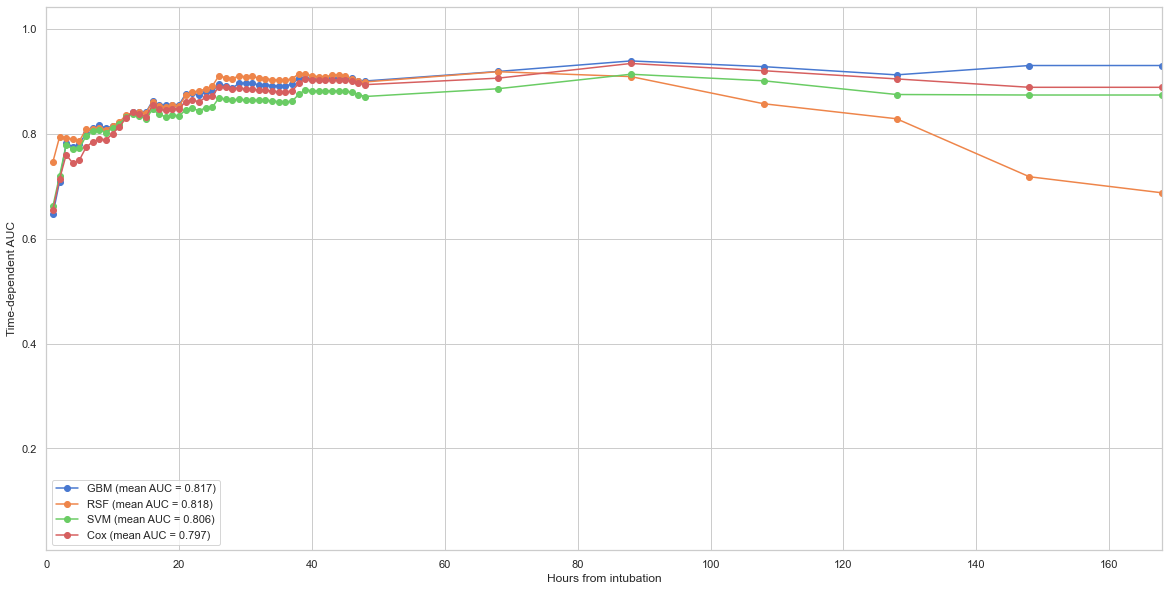

In [47]:
#Plotting time dependent C-Index
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set_theme(style='whitegrid',palette='muted')
plt.xlim(0, 168)
plt.plot(va_times, gbm_auc, "o-", label="GBM (mean AUC = {:.3f})".format(gbm_mean_auc))
plt.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.plot(va_times, svm_auc, "o-", label="SVM (mean AUC = {:.3f})".format(svm_mean_auc))
plt.plot(va_times, cph_auc, "o-", label="Cox (mean AUC = {:.3f})".format(cph_mean_auc))
plt.xlabel("Hours from intubation")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower left")
plt.grid(True)

#plt.savefig('Male_1/Time dependent AUC.png', dpi=300,  bbox_inches = "tight")


In [58]:
#%%
feature_names = Xt.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.1, stratify=y["Censor"], random_state=0)


#%%
random_state = 0

rsf = RandomSurvivalForest(min_samples_leaf=6)
rsf.fit(Scaler.transform(X_train),y_train)
permrsf = PermutationImportance(rsf, n_iter=1, random_state=random_state)
permrsf.fit(Scaler.transform(X_train), y_train)
eli5.show_weights(permrsf, feature_names=feature_names, top = 20)

gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**gbmbestparam)
gbm.fit(Scaler.transform(X_train),y_train)
permgbm = PermutationImportance(gbm, n_iter=1, random_state=random_state)
permgbm.fit(Scaler.transform(X_train), y_train)
eli5.show_weights(permgbm, feature_names=feature_names, top = 20)

svm = FastSurvivalSVM(tol=1e-5)
svm.set_params(**svmbestparam)
svm.fit(Scaler.transform(X_train),y_train)
permsvm = PermutationImportance(svm, n_iter=1, random_state=random_state)
permsvm.fit(Scaler.transform(X_train), y_train)
eli5.show_weights(permsvm, feature_names=feature_names, top = 20)


KeyboardInterrupt: 

### 2.4: Model fairness (sensitivity analysis)

#### 2.4.1: Gender

In [49]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Scaler = StandardScaler().fit(Xt, y=None)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.1, stratify=y["Censor"], random_state=0)

In [51]:
test_df = pd.merge(X_test.reset_index(), pd.DataFrame(y_test), left_index=True, right_index=True)
m_test_df = test_df[test_df['gender=M']==1]
f_test_df = test_df[test_df['gender=M']==0]
print(len(m_test_df),len(f_test_df))

X_test_M = m_test_df[[i for i in m_test_df.columns if i not in ['Survival','Censor','index']]]
y_test_M_ = m_test_df[['Survival','Censor']]
y_test_M = np.zeros(len(y_test_M_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_M['Censor'] = y_test_M_['Censor']
y_test_M['Survival'] = y_test_M_['Survival']

X_test_F = f_test_df[[i for i in f_test_df.columns if i not in ['Survival','Censor','index']]]
y_test_F_ = f_test_df[['Survival','Censor']]
y_test_F = np.zeros(len(y_test_F_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_F['Censor'] = y_test_F_['Censor']
y_test_F['Survival'] = y_test_F_['Survival']

717 326


In [52]:
# Male GBM
va_times_M = np.concatenate([np.arange(1, 48), np.arange(48, 672, 24)])
gbm_chf_funcs_M = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_M))
gbm_risk_scores_M = np.row_stack([chf(va_times_M) for chf in gbm_chf_funcs_M])

gbm_auc_M, gbm_mean_auc_M = cumulative_dynamic_auc(
    y_train, y_test_M, gbm_risk_scores_M, va_times_M
)

# Female GBM
va_times_F = np.concatenate([np.arange(1, 48), np.arange(48, 279, 24)])
gbm_chf_funcs_F = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_F))
gbm_risk_scores_F = np.row_stack([chf(va_times_F) for chf in gbm_chf_funcs_F])

gbm_auc_F, gbm_mean_auc_F = cumulative_dynamic_auc(
    y_train, y_test_F, gbm_risk_scores_F, va_times_F
)

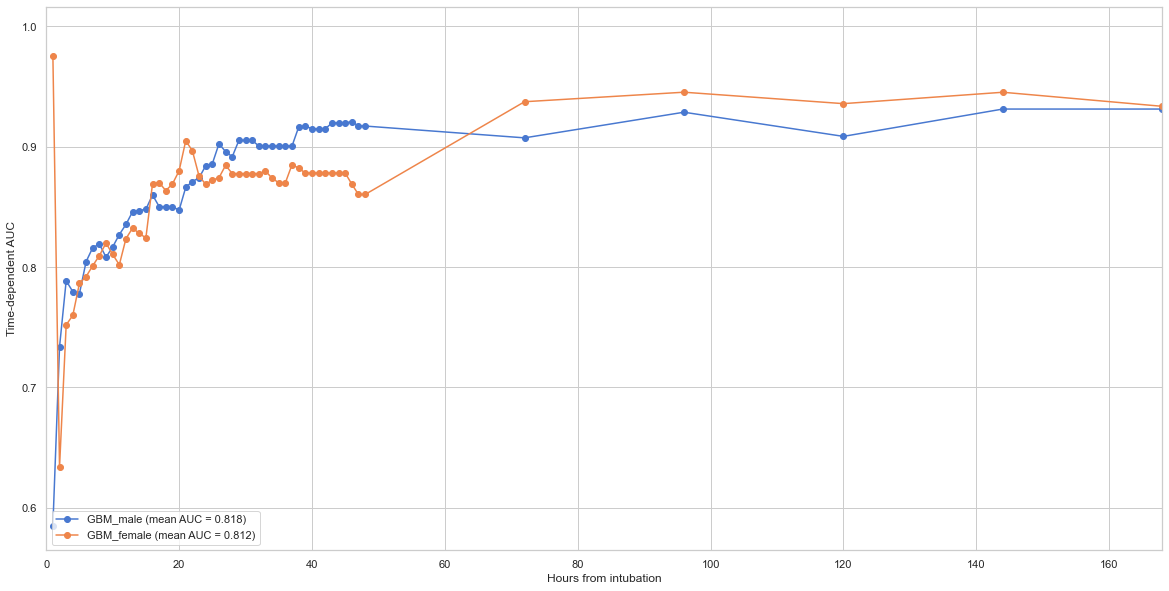

In [53]:
#Plotting time dependent C-Index
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set_theme(style='whitegrid',palette='muted')
plt.xlim(0, 168)
plt.plot(va_times_M, gbm_auc_M, "o-", label="GBM_male (mean AUC = {:.3f})".format(gbm_mean_auc_M))
plt.plot(va_times_F, gbm_auc_F, "o-", label="GBM_female (mean AUC = {:.3f})".format(gbm_mean_auc_F))
plt.xlabel("Hours from intubation")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower left")
plt.grid(True)

#plt.savefig('Male_1/Time dependent AUC.png', dpi=300,  bbox_inches = "tight")

#### 2.4.2: Ethnicity

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.1, stratify=y["Censor"], random_state=0)

In [55]:
test_df = pd.merge(X_test.reset_index(), pd.DataFrame(y_test), left_index=True, right_index=True)
test_df_white = test_df[test_df['ethnicity=white']==1]
test_df_notWhite = test_df[test_df['ethnicity=white']==0]
print(len(test_df_white),len(test_df_notWhite))

X_test_white = test_df_white[[i for i in test_df_white.columns if i not in ['Survival','Censor','index']]]
y_test_white_ = test_df_white[['Survival','Censor']]
y_test_white = np.zeros(len(y_test_white_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_white['Censor'] = y_test_white_['Censor']
y_test_white['Survival'] = y_test_white_['Survival']

X_test_notWhite = test_df_notWhite[[i for i in test_df_notWhite.columns if i not in ['Survival','Censor','index']]]
y_test_notWhite_ = test_df_notWhite[['Survival','Censor']]
y_test_notWhite = np.zeros(len(y_test_notWhite_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_notWhite['Censor'] = y_test_notWhite_['Censor']
y_test_notWhite['Survival'] = y_test_notWhite_['Survival']

876 167


In [56]:
# White GBM
va_times_white = np.concatenate([np.arange(1, 48), np.arange(48, 672, 24)])
gbm_chf_funcs_white = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_white))
gbm_risk_scores_white = np.row_stack([chf(va_times_white) for chf in gbm_chf_funcs_white])

gbm_auc_white, gbm_mean_auc_white = cumulative_dynamic_auc(
    y_train, y_test_white, gbm_risk_scores_white, va_times_white
)

# NotWhite GBM
va_times_notWhite = np.concatenate([np.arange(1, 48), np.arange(48, 192, 24)])
gbm_chf_funcs_notWhite = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_notWhite))
gbm_risk_scores_notWhite = np.row_stack([chf(va_times_notWhite) for chf in gbm_chf_funcs_notWhite])

gbm_auc_notWhite, gbm_mean_auc_notWhite = cumulative_dynamic_auc(
    y_train, y_test_notWhite, gbm_risk_scores_notWhite, va_times_notWhite
)

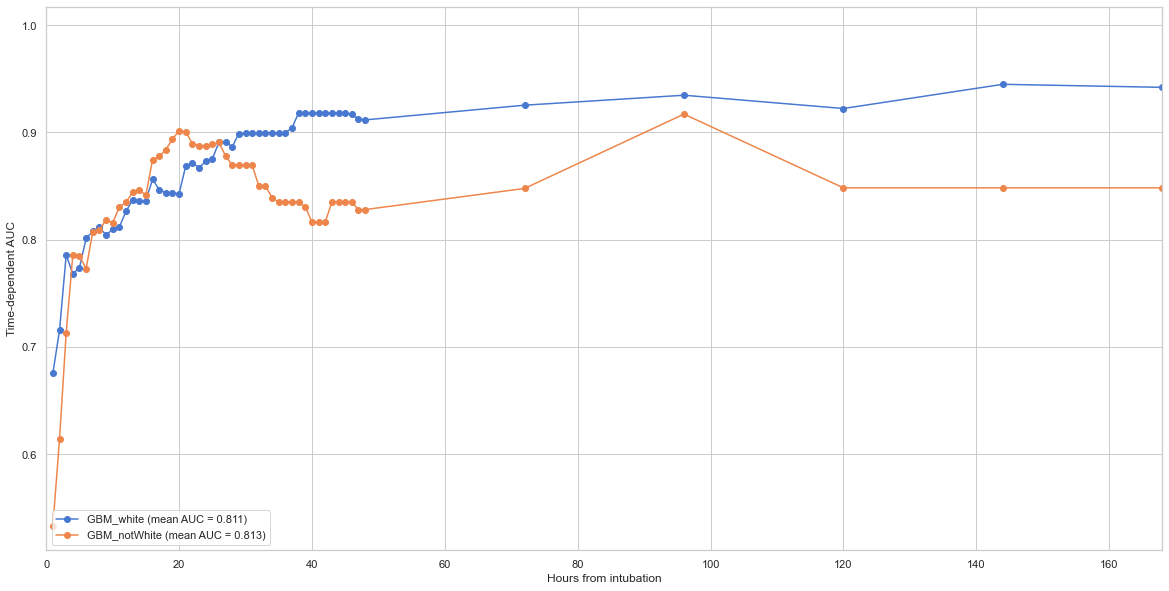

In [57]:
#Plotting time dependent C-Index
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set_theme(style='whitegrid',palette='muted')
plt.xlim(0, 168)
plt.plot(va_times_white, gbm_auc_white, "o-", label="GBM_white (mean AUC = {:.3f})".format(gbm_mean_auc_white))
plt.plot(va_times_notWhite, gbm_auc_notWhite, "o-", label="GBM_notWhite (mean AUC = {:.3f})".format(gbm_mean_auc_notWhite))
plt.xlabel("Hours from intubation")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower left")
plt.grid(True)

#plt.savefig('Male_1/Time dependent AUC.png', dpi=300,  bbox_inches = "tight")

In [1]:
[['ethnicity=white']==0 and ['duration1']>100]

NameError: name 'df' is not defined

## 3: Descriptive statistics

#### 3.1: Descriptive statistics

In [37]:
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

#for i in [i for i in Xt.columns if 'ethnicity' in i]:

descStats = pd.DataFrame()

for col in categorical:
    for i in [*[i for i in Xt.columns if col in i], *[i for i in proceduretype if i in Xt.columns], *[i for i in boolFields if i in Xt.columns]]:
        n =  pd.DataFrame(Xt[i].value_counts()).loc[1.0,i]
        pct = round(n/10430*100,1)
        descStats.at[i,'Total Cohort (n=10430)'] = f'{n} ({pct})'
descStats

KeyError: 1.0

In [ ]:
for i in [*[i for i in ptParams_first if i in Xt.columns], *[i for i in tsColumns_first if i in Xt.columns],'duration1']:
    avg = round(df[i].mean(), 1)
    std = round(df[i].std(), 1)
    pctile_25, med, pctile_75 = df[i].quantile([0.25,0.5,0.75])
    descStats.at[i,'Total Cohort (n=10430)'] = f'{med} ({pctile_25}-{pctile_75})'
descStats

,Total Cohort (n=10430)
ethnicity=black,393 (3.8)
ethnicity=hispanic,358 (3.4)
ethnicity=native,53 (0.5)
ethnicity=other,499 (4.8)
ethnicity=white,8843 (84.8)
...,...
rrset_first,15.4 (2.0)
rrtotal_first,16.3 (3.6)
rrspont_first,4.9 (7.4)
infection_first,0.0 (0.1)


#### 3.2: Mutual information

In [ ]:
pd.set_option('display.max_rows',10)
# get list of top variables by mutual information
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] = df['duration1']
y

#mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42))
mutual_info_df = pd.DataFrame(mutual_info_regression(Xt, y['Survival'], random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0],ascending=False)
mutual_info_df

,0
fio2_first,0.213600
prbc_first,0.202591
first_careunit=CVICU,0.192481
height,0.173899
first_careunit=CSRU,0.168067
...,...
language=RUSS,0.000000
language=PTUN,0.000000
language=GREE,0.000000
language=HAIT,0.000000


In [ ]:
for i in list(Xt.columns):
    mi = round(mutual_info_df.loc[i,0],3)
    descStats.at[i,'Mutual Information'] = f'{mi}'

In [ ]:
descStats

,Total Cohort (n=10430),Mutual Information
ethnicity=black,393 (3.8),0.0
ethnicity=hispanic,358 (3.4),0.001
ethnicity=native,53 (0.5),0.0
ethnicity=other,499 (4.8),0.0
ethnicity=white,8843 (84.8),0.001
...,...,...
rrset_first,15.4 (2.0),0.02
rrtotal_first,16.3 (3.6),0.017
rrspont_first,4.9 (7.4),0.101
infection_first,0.0 (0.1),0.007


#### 3.3 Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
Rsquared = pd.DataFrame()

for col in list(Xt.columns):
    X_ = Xt[col]
    X_ = np.array(X_, dtype=float).reshape(-1, 1)
    y_ = y['Survival']
    model = LinearRegression().fit(X_, y_)
    score = model.score(X_,y_)
    Rsquared.at[col, 'R2'] = '{s:.3f}'.format(s = score)
Rsquared

,R2
ethnicity=black,0.001
ethnicity=hispanic,0.001
ethnicity=native,0.001
ethnicity=other,0.000
ethnicity=white,0.003
...,...
mi,0.002
dementia,0.000
diab_un,0.000
diab_cc,0.000


In [ ]:
for i in list(Xt.columns):
    rsq = Rsquared.loc[i,'R2']
    descStats.at[i,'R2'] = f'{rsq}'

In [ ]:
descStats

,Total Cohort (n=10430),Mutual Information,R2
ethnicity=black,393 (3.8),0.0,0.001
ethnicity=hispanic,358 (3.4),0.001,0.001
ethnicity=native,53 (0.5),0.0,0.001
ethnicity=other,499 (4.8),0.0,0.000
ethnicity=white,8843 (84.8),0.001,0.003
...,...,...,...
rrset_first,15.4 (2.0),0.02,0.018
rrtotal_first,16.3 (3.6),0.017,0.003
rrspont_first,4.9 (7.4),0.101,0.000
infection_first,0.0 (0.1),0.007,0.000


In [ ]:
descStats.to_csv('descStats.csv')

## 4: Exploring language and ventilation duration 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

dfImputed_onehot = dfImputed.copy()
dfImputed1 = pd.get_dummies(dfImputed_onehot, columns = ['ethnicity', 'language'], prefix = ['eth', 'lang'])
onehot_cols = [i for i in list(dfImputed1.columns) if i not in ['ethnicity', 'marital_status', 'language', 'admission_location']]
dfImputed1['duration1'] = df['duration1']
dfImputed1 = dfImputed1.dropna(axis=0, how='any')

In [ ]:
dfImputed1

In [ ]:
from matplotlib import pyplot
from scipy.stats import kstest, norm, pearsonr, ttest_ind

x = dfImputed1['lang_ENGL']
y = df['duration1'].dropna(axis=0,how='any')

#testing for normalcy
mu, std = norm.fit(x)
n = norm(loc=mu, scale=std)
normalcy_p = kstest(x, n.cdf)[1]
print('p-val: '+ str(normalcy_p))

pyplot.scatter(x,y)
covariance = np.cov(x,y)
print('Covariance matrix: ')
print(covariance)

#find pearson R
corr, _ = pearsonr(x,y)
print('Pearsons R: %.3f' %corr)

In [ ]:
import statsmodels.api as sm

univariable = pd.DataFrame(index = ['eth_white','lang_ENGL'], columns = ['OR (95% CI)','p-value'])

p_value = []
OR = []
time = []
for column in ['lang_ENGL']:
    for int_timelimit in range(0,48,1):
        X = dfImputed1[column].values
        X = sm.add_constant(X)
        y = pd.cut(df['duration1'].dropna(how='any'),bins=[-0.1,int_timelimit,4000],labels=[0,1])
        logit = sm.Logit(y, X)
        model = logit.fit(method='bfgs',disp = False)
        model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
        model_odds['p-value'] = model.pvalues
        model_odds[['2.5%','97.5%']]= np.exp(model.conf_int())
        model_odds.rename(index={'x1': column}, inplace = True)
        # insert it into the dataframe 'univariable'
        univariable.at[column,'OR (95% CI)'] = '{OR:.3f} ({lower:.3f} to {upper:.3f})'.format(OR = model_odds.at[column, 'OR'], 
                                                                                            lower = model_odds.at[column, '2.5%'], 
                                                                                            upper = model_odds.at[column, '97.5%'])
        univariable.at[column,'p-value'] = '{0:.3f}'.format(model_odds.at[column, 'p-value'])
        p_value.append(model_odds.at[column, 'p-value'])
        OR.append(model_odds.at[column, 'OR'])
        time.append(int_timelimit)

univariable

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(time, OR, label='OR',color='blue')
ax.set_xlabel("ventilation time")
ax.set_ylabel("OR")

ax2=ax.twinx()
ax2.plot(time, p_value, label='p-val',color='orange')
ax2.set_ylabel("p-val")


In [ ]:
x1 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==1].dropna(axis=0,how='any')
x2 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==0].dropna(axis=0,how='any')
plt.hist(x1,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60))
plt.hist(x2,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60),color='orange')
print('mean English: '+str(np.mean(x1)))
print('mean non-English: '+str(np.mean(x2)))
print('t_test p-val;: '+str(ttest_ind(x1, x2)[1]))

## 5: Graveyard

In [ ]:
# to test different numbers of selected variables

y_ = []
x_ = []
for i in list(range(50,144,10)):
    Xt = OneHotEncoder().fit_transform(X)
    how_many_select = i
    mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
    mutual_info_df = mutual_info_df.sort_values(by=[0])
    inc_var = list(mutual_info_df.index)[-how_many_select:]
    Xt = Xt[inc_var]
    cph = CoxPHSurvivalAnalysis()
    cph.fit(Xt, y)

    # get c-index of trained estimator
    pred = cph.predict(Xt)
    result = concordance_index_censored(y['Censor'], y["Survival"], pred)
    print('C-index of Cox model: '+str(result[0]))
    x_.append(i)
    y_.append(result[0])

plt.plot(y_,x_)

KeyboardInterrupt: 

In [ ]:
# get list of top variables by mutual
how_many_select = 110

mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0])
inc_var = list(mutual_info_df.index)[-how_many_select:]

Xt = Xt[inc_var]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

In [ ]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train)

# get c-index of trained estimator
pred = cph.predict(X_test)
result = concordance_index_censored(y_test['Censor'], y_test["Survival"], pred)
print('C-index of Cox model: '+str(result[0]))

LinAlgError: Matrix is singular.

In [ ]:
alphas = 10. ** np.linspace(-4,4,10)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train, y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(X_train.columns))

NameError: name 'X_train' is not defined

AttributeError: 'dict' object has no attribute 'shape'

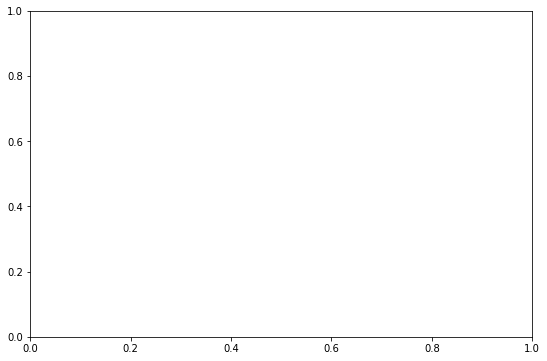

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
plot_coefficients(coefficients, n_highlight=10)

In [ ]:
'''# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})
y['Censor'] = df['censor']
y['Survival'] = df['duration1']'''

'''X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.06, random_state=1)
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train)

# get c-index of trained estimator
pred = cph.predict(X_test)
result = concordance_index_censored(y_test['Censor'], y_test["Survival"], pred)
print('C-index of Cox model: '+str(result[0]))'''

'''
for col in list(Xt.columns):
    try:
        Xt_ = Xt.drop([col],axis=1)
        X_train, X_test, y_train, y_test = train_test_split(Xt_, y, test_size=0.2, random_state=42)
        cph = CoxPHSurvivalAnalysis()
        cph.fit(X_train, y_train)

        # get c-index of trained estimator
        pred = cph.predict(X_test)
        result = concordance_index_censored(y_test['Censor'], y_test["Survival"], pred)
        print('C-index of Cox model: '+str(result[0]))
        print('Column is: '+col)
    except:
        continue
'''

In [ ]:
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score

# configure the cross-validation procedure
cv_init = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
cv_results = list()
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

for model in :
	model_results = list()
	for train_ix, test_ix in cv_init.split(Xt):
		# split data
		X_train, X_test = Xt.to_numpy()[train_ix, :], Xt.to_numpy()[test_ix, :]
		y_train, y_test = y[train_ix], y[test_ix]

		model = model.fit(X_train, y_train)
		acc = score_survival_model(model, X_test, y_test)
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		# evaluate the model
		acc = concordance_index_censored(y_test, yhat)
		# store the result
		model_results.append(acc)
		# report progress
		print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
		
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

### Random Survival Forest

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

array([( True, 3.        ), ( True, 2.68333333), ( True, 3.25      ), ...,
       ( True, 9.        ), ( True, 3.        ), ( True, 6.        )],
      dtype=[('Censor', '?'), ('Survival', '<f8')])

In [ ]:
# Initialise cross validation and scoring function

cv = KFold(n_splits=2, shuffle=True, random_state=0)
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

In [ ]:
#1. RF
rsf = RandomSurvivalForest()
parameters = {'n_estimators': list(range(50,500,10)),
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}
gcvrf = RandomizedSearchCV(
    rsf,
    parameters,
    n_iter=2,
    cv=cv,
    scoring = score_survival_model,
    random_state = 0,
    n_jobs=-1, verbose=5).fit(Xt, y)


#%%
rf_cv_results = pd.DataFrame(gcvrf.cv_results_)
print(rf_cv_results)
#rf_cv_results.to_csv('Male_1/RF Grid CV With scorer specified.csv')

Fitting 2 folds for each of 2 candidates, totalling 4 fits


NotFittedError: All estimators failed to fit

In [ ]:
#2. GBM
gbm = GradientBoostingSurvivalAnalysis()
parameters = {'learning_rate': [1,0.1,0.01], 'n_estimators': [100,200,300]}
gcvgbm = RandomizedSearchCV(
    gbm,
    parameters,
    n_iter=4,
    cv=cv,
    scoring = score_survival_model,
    random_state = 0,
    n_jobs=-1, verbose=2).fit(Xt, y)

# get results
gbm_cv_results = pd.DataFrame(gcvgbm.cv_results_)
print(gbm_cv_results)
#gbm_cv_results.to_csv('Male_1/GBM Grid CV With scor cer specified.csv')


In [ ]:
#3. SVM
svm = FastSurvivalSVM(tol=1e-5)
parameters = {'max_iter': [20,100,500,1000]}
gcvsvm = RandomizedSearchCV(
    svm,
    parameters,
    n_iter=4,
    cv=cv,
    scoring = score_survival_model,
    random_state = 0,
    n_jobs=-1, verbose=2).fit(Xt, y)

svm_cv_results = pandas.DataFrame(gcvsvm.cv_results_)
print(svm_cv_results)
#svm_cv_results.to_csv('Male_1/SVM Grid CV With scorer specified.csv')

In [ ]:
rsf = RandomSurvivalForest(n_estimators=50,
                            min_samples_split=50,
                            min_samples_leaf=2,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=0)

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

gcvrf = GridSearchCV(
    rsf,
    param_grid = {'max_features': ['log2','auto','sqrt'], 'n_estimators':[100,200,300]},
    cv=cv,
    scoring = score_survival_model,
    n_jobs=4, verbose=2).fit(Xt, y)

In [ ]:
rfbestparam = {'min_samples_leaf': 8, 'n_estimators': 100}
gbmbestparam = {'learning_rate': 0.3, 'n_estimators': 100}
svmbestparam = {'alpha': 0.1, 'max_iter': 100}
coxbestparam = {'coxnetsurvivalanalysis__alphas': [best_alpha]}

In [ ]:
from sklearn.model_selection import cross_val_score

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

rf_scores = cross_val_score(RandomSurvivalForest(**rfbestparam), Xt, y, cv=5, scoring=score_survival_model)

In [ ]:
rf_scores

array([0.75195177, 0.75014071, 0.70053968, 0.69796599, 0.69771363])

In [ ]:
gbm_scores = cross_val_score(GradientBoostingSurvivalAnalysis(**gbmbestparam), Xt, y, cv=5, scoring=score_survival_model)
print(gbm_scores)

[0.76150157 0.75300084 0.71939301 0.71660354 0.71862885]


In [ ]:
svm_scores = cross_val_score(FastSurvivalSVM(**svmbestparam), Xt, y, cv=5, scoring=score_survival_model)


[0.74772016 0.7430254  0.69859203 0.68483153 0.69147491]


In [ ]:
coxnet = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.5)
)
coxnet.set_params(**coxbestparam)
cox_scores = cross_val_score(coxnet, Xt, y, cv=5, scoring=score_survival_model)
print(cox_scores.mean())

0.7095437857328761


In [ ]:
print('RF: %.3f (%.3f)' % (rf_scores.mean(), rf_scores.std()))
print('GBM: %.3f (%.3f)' % (gbm_scores.mean(), gbm_scores.std()))
print('SVM: %.3f (%.3f)' % (svm_scores.mean(), svm_scores.std()))
print('Cox: %.3f (%.3f)' % (cox_scores.mean(), cox_scores.std()))

RF: 0.720 (0.026)
GBM: 0.734 (0.019)
SVM: 0.713 (0.027)
Cox: 0.710 (0.029)


In [ ]:
#%%
#Time-dependent evaluation
x_train, x_test, y_train, y_test = train_test_split(
    x_full, y_full, test_size=0.1, stratify=y_full["Censor"], random_state=0)

#%%
#Make sure to put optimal model features here
#1. RF
#rsf = RandomSurvivalForest(n_estimators=, min_samples_leaf=, random_state=0)
rsf.set_params(**gcvrf.best_params_)
rsf.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)

#2. GBM
#gbm = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**gcvgbm.best_params_)
gbm.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
gbm_chf_funcs = gbm.predict_cumulative_hazard_function(
    x_test)
gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])

gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, gbm_risk_scores, va_times
)

#3. SVM
#svm = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)
svm = FastSurvivalSVM(tol=1e-5)
svm.set_params(**gcvsvm.best_params_)
svm.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
svm_chf_funcs = svm.predict(
    x_test)
svm_auc, svm_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, svm_chf_funcs, va_times
)

#4. CoxNet
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcvlinear.best_params_)
coxnet_pred.fit(x_train, y_train)
cph_risk_scores = coxnet_pred.predict(x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, cph_risk_scores, va_times
)


In [ ]:
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score

# configure the cross-validation procedure
cv_outer = KFold(n_splits=3, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
ci_scorer = make_scorer(RandomSurvivalForest().score)
count = 0
for train_ix, test_ix in cv_outer.split(Xt):
	# split data
	if count == 0:
		count += 1
		X_train, X_test = Xt.to_numpy()[train_ix, :], Xt.to_numpy()[test_ix, :]
		y_train, y_test = y[train_ix], y[test_ix]
		print(y_test)
		# configure the cross-validation procedure
		cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
		# define the model
		model = RandomSurvivalForest(n_estimators=50,
								min_samples_split=50,
								min_samples_leaf=2,
								max_features="sqrt",
								n_jobs=-1,
								random_state=42)

		rsf = RandomSurvivalForest()
		parameters = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)],
					'max_features': ['auto', 'sqrt'],
					'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
					'min_samples_split': [2, 5],
					'min_samples_leaf': [1, 2, 4],
					'bootstrap': [True, False]}
		rsf_tuned = RandomizedSearchCV(rsf, parameters, n_iter = 2, cv=2, n_jobs=-1, scoring=ci_scorer)
		# execute search
		result = rsf_tuned.fit(X_train, y_train)
		# get the best performing model fit on the whole training set
		best_model = result.best_estimator_
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		# evaluate the model
		acc = concordance_index_censored(y_test, yhat)
		# store the result
		outer_results.append(acc)
		# report progress
		print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
	else:
		break
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

In [ ]:
rsf = RandomSurvivalForest()
parameters = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}
rsf_tuned = RandomizedSearchCV(rsf, parameters, n_iter = 5, cv=3, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RSF: {}'.format(rsf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rsf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rsf_tuned.predict(X_test))))

In [ ]:
'''rsf = RandomSurvivalForest(n_estimators=200,
                            min_samples_split=50,
                            min_samples_leaf=3,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)
parameters = {'n_estimators': [100, 200],
              'max_features': ['auto'],
              'max_depth': [50, 100],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,10],
              'bootstrap': [True, False]}
rsf_tuned = GridSearchCV(rsf, parameters, cv=5, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RF: {}'.format(rf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rf_tuned.predict(x_test))))'''

In [ ]:
feature_names = X_train.columns.tolist()
perm = PermutationImportance(rsf, n_iter=3, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

###  GBM Survival

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
how_many_select = 100

mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0])
inc_var = list(mutual_info_df.index)[-how_many_select:]

Xt = Xt[inc_var]

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

# get X_train, X_test, y_train, y_test
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.2, random_state=random_state)

In [ ]:
df['censor']

In [ ]:
'''Xt.to_csv('Xt_vent.csv')
df['duration1'].to_csv('t_vent.csv')
df['censor'].to_csv('e_vent.csv')
'''

In [ ]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
        loss='coxph', n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
    )

est_cph_tree.fit(X_train, y_train)
est_cph_tree.pr
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

In [ ]:
est_cph_tree.(X_train)

In [ ]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(10, 31,5):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

### XGB

In [ ]:
# models and metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgbse.metrics import concordance_index
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

# setting seed
np.random.seed(42)

# to easily plot confidence intervals

def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

# to write data as markdown for publication

def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    df.columns = df.columns.astype(str)
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

dtrain = xgb.DMatrix(Xt)
dtrain

## pre selected params for models ##

PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50, 
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 100, 
    'booster':'dart', 
    'subsample': 1.0,
    'min_child_weight': 50, 
    'colsample_bynode': 1.0
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

TIME_BINS = np.arange(15, 315, 15)


In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y=convert_to_structured(df['duration1'],df['censor'])

# get X_train, X_test, y_train, y_test
(X_train, X_valid,
 y_train, y_valid) = \
train_test_split(Xt, y, test_size=0.2, random_state=42)

In [ ]:
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:aft')

# training model
bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')
print(f"C-index: {cind:.3f}")
print(f"Average survival time: {preds.mean():.0f} days")

In [ ]:
# saving predictions to plot later
preds_dict = {}

# loop to show different scale results
for scale in [1.0, 0.5, 0.25, 0.1]:
    
    # chaning parameter
    PARAMS_XGB_AFT['aft_loss_distribution_scale'] = scale
    
    # training model
    bst = xgb.train(
        PARAMS_XGB_AFT,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')

    preds_dict[scale] = preds

    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average survival time: {preds.mean():.0f} days")
    print("----")

In [ ]:
from xgbse.non_parametric import calculate_kaplan_vectorized

TIME_BINS = np.arange(0, 100, 5)

mean, high, low = calculate_kaplan_vectorized(
    y['c2'].reshape(1,-1),
    y['c1'].reshape(1,-1),
    TIME_BINS
)

plt.figure(figsize=(12,4), dpi=120)
plt.plot(mean.columns, mean.iloc[0], 'k--', label='Kaplan Meier (unbiased estimator for survival)')

for i, scale in enumerate([1.0, 0.5, 0.25, 0.1]):
    plt.axvline(
        preds_dict[scale].mean(),
        label=f'Model average prediction\n(aft_loss_distribution_scale = {scale})',
        linewidth=2, 
        alpha=0.5,
        color=f'C{i}'
    )

plt.title('Vanilla XGB Average prediction vs. Kaplan Meier (unbiased estimator for survival)')
plt.legend()

In [ ]:
params = {'objective': 'survival:aft',
          'eval_metric': 'aft-nloglik',
          'aft_loss_distribution': 'normal',
          'aft_loss_distribution_scale': 1.20,
          'tree_method': 'hist', 'learning_rate': 0.05, 'max_depth': 2}
bst = xgb.train(params, dtrain, num_boost_round=1000,
                evals=[(dtrain, 'train')])
preds=bst.predict(dtrain)
cind=concordance_index(y)

### Deep Survival

In [ ]:
from dsm import DeepSurvivalMachines
from dsm import datasets
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
import numpy as np

# load the SUPPORT dataset.
x, t, e = datasets.load_dataset('SUPPORT')
x = pd.read_csv('/Xt_vent.csv').to_numpy()
t = pd.read_csv('/t_vent.csv').values
t = np.delete(t, 0, 1).flatten()
e = np.ones(len(x))
print('x', type(x), type(e[1]), x[1].shape)
print('t', type(t), type(e[1]), t[1].shape)
print('e', type(e), type(e[1]), e[1].shape)

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size=0.2, random_state=42)
print(x_train, x_test, t_train, t_test, e_train, e_test)
horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e==1], horizons).tolist()
'''# instantiate a DeepSurvivalMachines model.
model = DeepSurvivalMachines()
# fit the model to the dataset.
model.fit(x_train, t_train, e_train)
# estimate the predicted risks at the time
pred = model.predict_risk(x_train, 10)
print(pred)
'''
from dsm.contrib import DeepCoxMixtures
model = DeepCoxMixtures()
model.fit(x_train, t_train, e_train, iters=40000, batch_size=32)
pred_t = model.predict_survival(x_test, times)
print(pred_t)

In [ ]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
import numpy as np
cis = []
brs = []

pred=np.transpose(pred_t)

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, 1-pred[i], times[i])[0])
    

for i, _ in enumerate(times):
    brs.append(float(brier_score(et_train, et_test, pred[i], times[i])[1]))
    
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, 1-pred[i], times[i])[0])
for quantile in enumerate(horizons):
    print(f"For {quantile[1]} quantile,")
    print("TD Concordance Index:", cis[quantile[0]])
    print("Brier Score:", brs[quantile[0]])
    print("ROC AUC ", roc_auc[quantile[0]][0], "\n")

In [ ]:
from dsm import DeepSurvivalMachines
from dsm import datasets
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
import numpy as np

# load the SUPPORT dataset.
x, t, e = datasets.load_dataset('SUPPORT')
x = pd.read_csv('/Xt_vent.csv').to_numpy()
t = pd.read_csv('/t_vent.csv').values
t = np.delete(t, 0, 1).flatten()
e = np.ones(len(x))
print('x', type(x), type(e[1]), x[1].shape)
print('t', type(t), type(e[1]), t[1].shape)
print('e', type(e), type(e[1]), e[1].shape)

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size=0.2, random_state=42)
print(x_train, x_test, t_train, t_test, e_train, e_test)
horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e==1], horizons).tolist()
'''# instantiate a DeepSurvivalMachines model.
model = DeepSurvivalMachines()
# fit the model to the dataset.
model.fit(x_train, t_train, e_train)
# estimate the predicted risks at the time
pred = model.predict_risk(x_train, 10)
print(pred)
'''
from dsm.contrib import DeepCoxMixtures
from dsm.contrib.dcm_torch import DeepCoxMixturesTorch 
from dsm.contrib.dcm_utilities import train_dcm, fit_breslow
import torch 
#model = DeepCoxMixtures(k=50)
model = DeepCoxMixturesTorch(k=50, inputdim=x_train.shape[1])
# breslow = fit_breslow(model, x_train, t_train, e_train)
model, breslow = train_dcm(
    model, 
    (torch.from_numpy(x_train).type(torch.DoubleTensor), torch.from_numpy(t_train).type(torch.DoubleTensor), torch.from_numpy(e_train).type(torch.DoubleTensor)),
    (torch.from_numpy(x_train).type(torch.DoubleTensor), torch.from_numpy(t_train).type(torch.DoubleTensor), torch.from_numpy(e_train).type(torch.DoubleTensor)),
    epochs=200, lr=1e-3, bs=128, 
    use_posteriors=False,
    random_state=0,
    return_losses=True,
    patience=3,
    )
# model.fit(x_train, t_train, e_train, iters=1000, batch_size=128)
pred_t = model.predict_survival(x_test, times)
print(pred_t)